In [29]:
import os
import cv2
import seaborn as sn 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import glob as glob
from sklearn.model_selection import train_test_split
import csv
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report  
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.utils import class_weight

In [4]:
color = 'rgb' #'grayscale' o 'rgb'

escala = 150

In [3]:
def cargar_datos(path1, path2, escala = escala, color = color):
    
    EMD = os.listdir(path1)
    NO_EMD = os.listdir(path2)
    
    data = []
    labels = []

    for i in EMD:   
        image=tf.keras.preprocessing.image.load_img(path1+'/'+i, color_mode= color, 
        target_size= (escala, escala))
        image=np.array(image)
        data.append(image)
        labels.append(1)
    for i in NO_EMD:   
        image=tf.keras.preprocessing.image.load_img(path2+'/'+i, color_mode= color, 
        target_size= (escala, escala))
        image=np.array(image)
        data.append(image)
        labels.append(0)
        
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

# A. Creando los balanceadores manualmente

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

### TRAIN: OCT + Samsung

### TEST: iPhone

In [6]:
dataset_iphone = cargar_datos('Datos EMD/iPhone/EMD', 'Datos EMD/iPhone/NO EMD')

In [7]:
dataset_samsung = cargar_datos('Datos EMD/Samsung/EMD', 'Datos EMD/Samsung/NO EMD')

In [8]:
dataset = cargar_datos('Datos EMD/OCT/EMD', 'Datos EMD/OCT/NO EMD')

In [9]:
train_ds = np.concatenate((dataset[0],dataset_samsung[0]))

train_labels = np.concatenate((dataset[1],dataset_samsung[1]))

In [10]:
print(len(train_ds)==len(train_labels))

True


In [11]:
test_ds = dataset_iphone[0]

test_labels = dataset_iphone[1]

In [12]:
train_labels = to_categorical(train_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)

In [13]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [14]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [15]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

**Ver la clasificación de los datos**

In [16]:
emd = 0
no_emd = 0

for e in train_labels:
    if (e[0] == 0):
        emd+=1
    else:
        no_emd+=1

print(emd, no_emd)

62 160


**Crear los balanceadores**

In [17]:
weight_emd = (1/emd) * ((emd+no_emd) / 2.0)
weight_no_emd = (1/no_emd) * ((emd+no_emd) / 2.0)

class_weight = {0: weight_emd, 1: weight_no_emd}

print('Weight for class 0: {:.2f}'.format(weight_emd))
print('Weight for class 1: {:.2f}'.format(weight_no_emd))

Weight for class 0: 1.79
Weight for class 1: 0.69


In [18]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20,  restore_best_weights=True)

history = model.fit(train_ds, train_labels, epochs=200, validation_split=0.2, batch_size=32, callbacks=[es], class_weight=class_weight)

Epoch 1/200
6/6 [==============================] - 10s 2s/step - loss: 5.6787 - accuracy: 0.6441 - val_loss: 0.0760 - val_accuracy: 0.9778
Epoch 2/200
6/6 [==============================] - 9s 1s/step - loss: 0.7599 - accuracy: 0.7966 - val_loss: 2.2299 - val_accuracy: 0.0667
Epoch 3/200
6/6 [==============================] - 9s 1s/step - loss: 0.4382 - accuracy: 0.8305 - val_loss: 0.4065 - val_accuracy: 0.8889
Epoch 4/200
6/6 [==============================] - 10s 2s/step - loss: 0.3340 - accuracy: 0.8192 - val_loss: 0.6827 - val_accuracy: 0.8444
Epoch 5/200
6/6 [==============================] - 11s 2s/step - loss: 0.2963 - accuracy: 0.7966 - val_loss: 0.4459 - val_accuracy: 0.8222
Epoch 6/200
6/6 [==============================] - 11s 2s/step - loss: 0.2429 - accuracy: 0.8136 - val_loss: 1.0959 - val_accuracy: 0.6889
Epoch 7/200
6/6 [==============================] - 11s 2s/step - loss: 0.1952 - accuracy: 0.8192 - val_loss: 1.2900 - val_accuracy: 0.6000
Epoch 8/200
6/6 [============

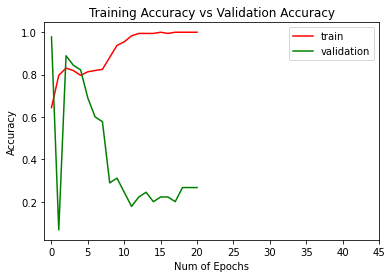

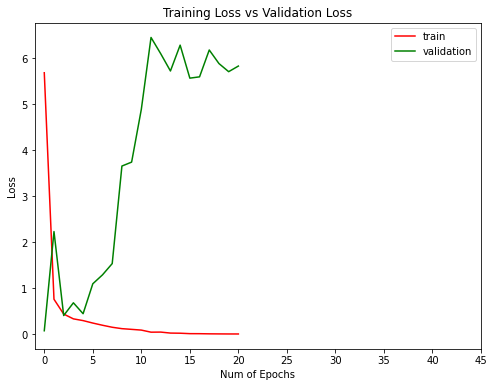

In [19]:
plt.figure(0)  
plt.plot(history.history['accuracy'],'r')  
plt.plot(history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()  

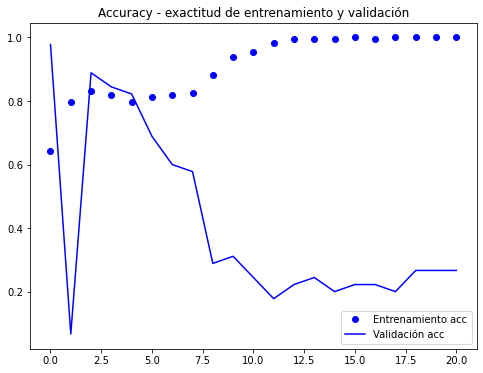

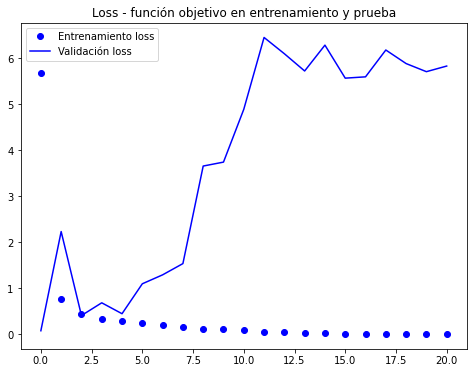

In [20]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

4/4 [==============================] - 5s 1s/step


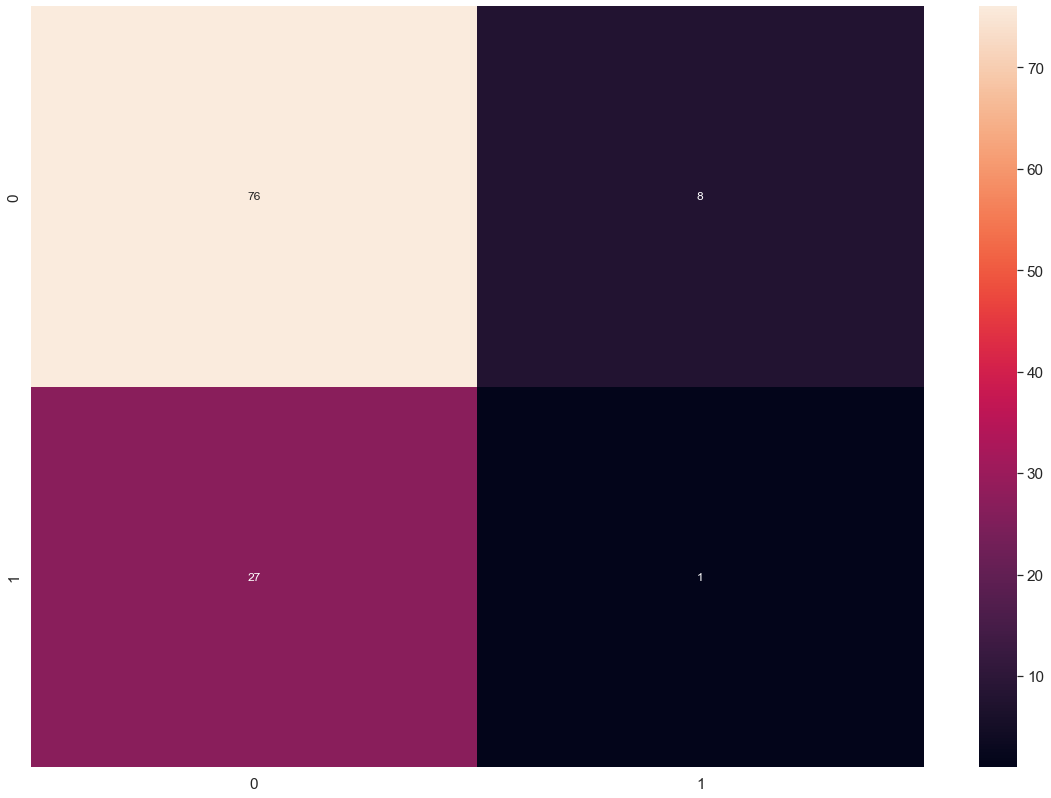

In [22]:
vgg16 = model.predict(test_ds, batch_size=32, verbose=1)  
vgg16_predicted = np.argmax(vgg16, axis=1)

vgg_cm = confusion_matrix(np.argmax(test_labels, axis=1), vgg16_predicted)

# Visualizing of confusion matrix
vgg_df_cm = pd.DataFrame(vgg_cm, range(2), range(2))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(vgg_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show() 

# B. Empleando la función class_weight

### TRAIN: OCT + Samsung

### TEST: iPhone

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

https://stackoverflow.com/questions/60408901/sklearn-utils-compute-class-weight-function-for-large-dataset

https://stackoverflow.com/questions/52726225/keras-class-weights

In [23]:
train_ds = np.concatenate((dataset[0],dataset_samsung[0]))

train_labels = np.concatenate((dataset[1],dataset_samsung[1]))

In [24]:
test_ds = dataset_iphone[0]

test_labels = dataset_iphone[1]

In [25]:
train_labels_categorical = to_categorical(train_labels, num_classes=2)
test_labels_categorical = to_categorical(test_labels, num_classes=2)

In [26]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [27]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

**Empleo compute_class_weight**

In [30]:
classes = np.unique(train_labels)

class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=train_labels)

dic_class_weights = {0:class_weights[0], 1:class_weights[1]}

In [31]:
print(dic_class_weights)

{0: 0.69375, 1: 1.7903225806451613}


In [32]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20,  restore_best_weights=True)

history = model.fit(train_ds, train_labels_categorical, epochs=200, validation_split=0.2, batch_size=32, callbacks=[es], class_weight=dic_class_weights)

Epoch 1/200
6/6 [==============================] - 10s 2s/step - loss: 7.3707 - accuracy: 0.4689 - val_loss: 3.2486 - val_accuracy: 0.4889
Epoch 2/200
6/6 [==============================] - 9s 2s/step - loss: 1.2657 - accuracy: 0.8023 - val_loss: 10.9003 - val_accuracy: 0.0444
Epoch 3/200
6/6 [==============================] - 9s 1s/step - loss: 0.8644 - accuracy: 0.7062 - val_loss: 3.9066 - val_accuracy: 0.3556
Epoch 4/200
6/6 [==============================] - 10s 2s/step - loss: 0.4124 - accuracy: 0.8814 - val_loss: 5.0701 - val_accuracy: 0.2222
Epoch 5/200
6/6 [==============================] - 11s 2s/step - loss: 0.2136 - accuracy: 0.8814 - val_loss: 3.9649 - val_accuracy: 0.4000
Epoch 6/200
6/6 [==============================] - 11s 2s/step - loss: 0.1575 - accuracy: 0.9605 - val_loss: 3.8725 - val_accuracy: 0.3778
Epoch 7/200
6/6 [==============================] - 11s 2s/step - loss: 0.0833 - accuracy: 0.9718 - val_loss: 3.9721 - val_accuracy: 0.3333
Epoch 8/200
6/6 [===========

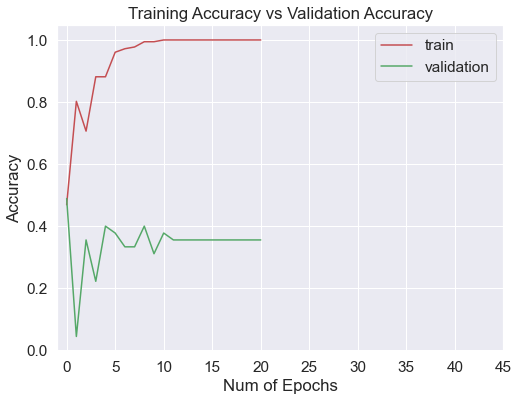

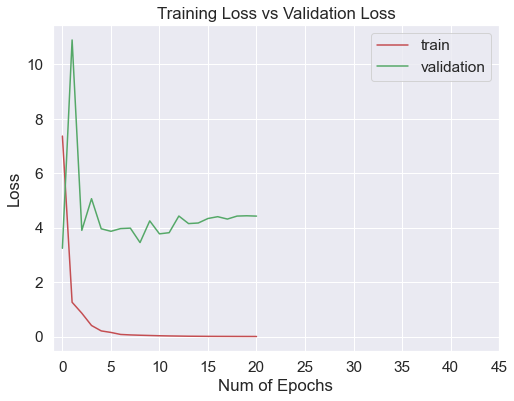

In [33]:
plt.figure(0)  
plt.plot(history.history['accuracy'],'r')  
plt.plot(history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

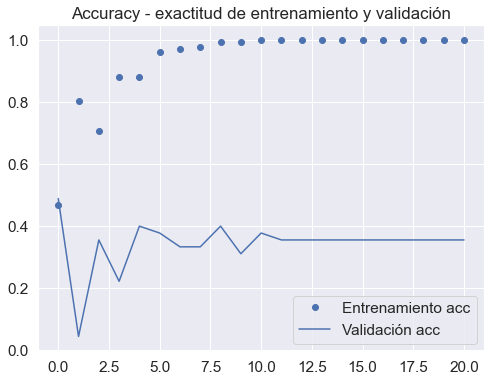

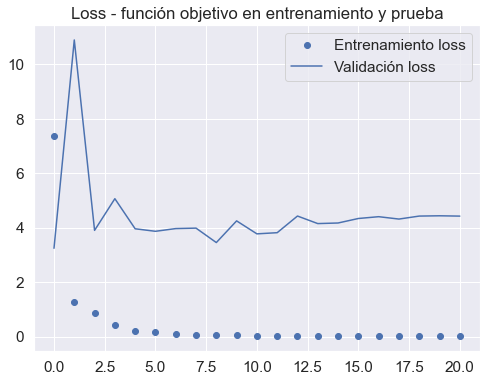

In [34]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

4/4 [==============================] - 5s 1s/step


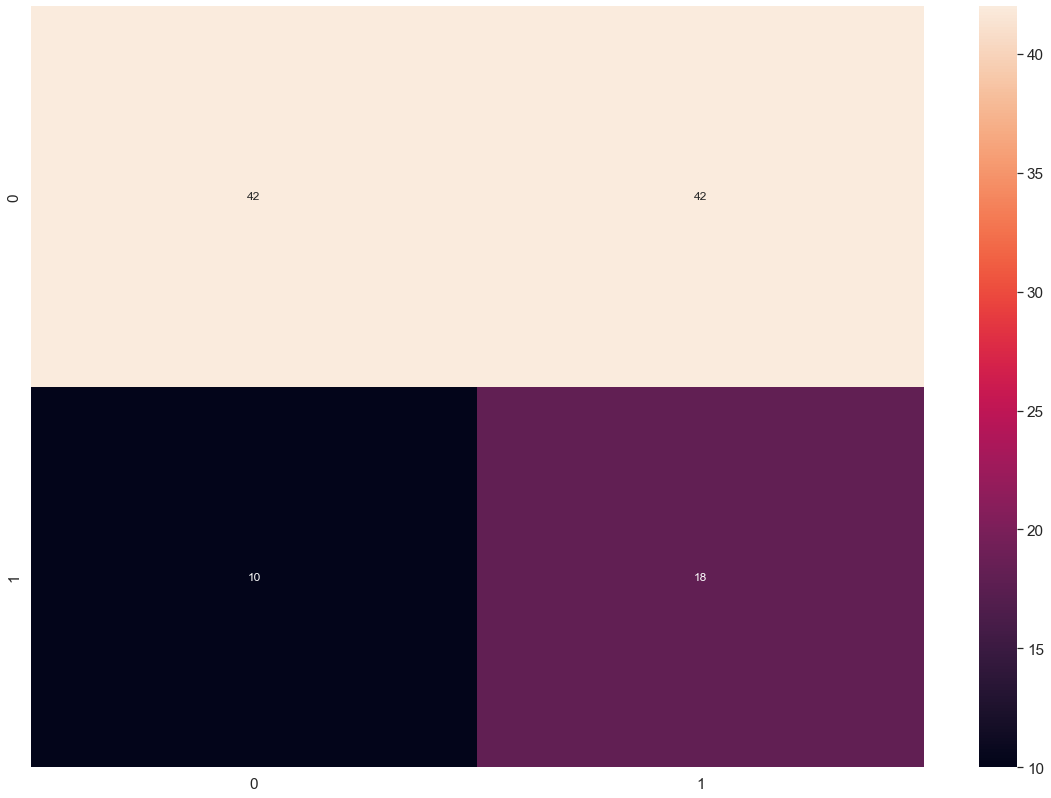

In [35]:
vgg16 = model.predict(test_ds, batch_size=32, verbose=1)  
vgg16_predicted = np.argmax(vgg16, axis=1)

vgg_cm = confusion_matrix(np.argmax(test_labels_categorical, axis=1), vgg16_predicted)

# Visualizing of confusion matrix
vgg_df_cm = pd.DataFrame(vgg_cm, range(2), range(2))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(vgg_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show() 

### TRAIN: OCT + iPhone

### TEST: Samsung

In [36]:
train_ds = np.concatenate((train_ds, dataset_iphone[0]))

train_labels = np.concatenate((train_labels, dataset_iphone[1]))

In [37]:
test_ds = dataset_samsung[0]

test_labels = dataset_samsung[1]

In [38]:
train_labels_categorical = to_categorical(train_labels, num_classes=2)

test_labels_categorical = to_categorical(test_labels, num_classes=2)

In [39]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [40]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [41]:
classes = np.unique(train_labels)

class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=train_labels)

dic_class_weights = {0:class_weights[0], 1:class_weights[1]}

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20,  restore_best_weights=True)

history = model.fit(train_ds, train_labels_categorical, epochs=200, validation_split=0.2, batch_size=32, callbacks=[es], class_weight=dic_class_weights)

Epoch 1/200
9/9 [==============================] - 15s 2s/step - loss: 6.0679 - accuracy: 0.5431 - val_loss: 0.2529 - val_accuracy: 0.9104
Epoch 2/200
9/9 [==============================] - 14s 2s/step - loss: 1.9478 - accuracy: 0.6030 - val_loss: 10.8545 - val_accuracy: 0.0448
Epoch 3/200
9/9 [==============================] - 15s 2s/step - loss: 1.1912 - accuracy: 0.7491 - val_loss: 3.3960 - val_accuracy: 0.3731
Epoch 4/200
9/9 [==============================] - 17s 2s/step - loss: 0.4580 - accuracy: 0.8315 - val_loss: 4.2750 - val_accuracy: 0.2687
Epoch 5/200
9/9 [==============================] - 17s 2s/step - loss: 0.2783 - accuracy: 0.8914 - val_loss: 4.6489 - val_accuracy: 0.3284
Epoch 6/200
9/9 [==============================] - 17s 2s/step - loss: 0.0897 - accuracy: 0.9588 - val_loss: 3.4594 - val_accuracy: 0.4328
Epoch 7/200
9/9 [==============================] - 17s 2s/step - loss: 0.0301 - accuracy: 0.9925 - val_loss: 2.5163 - val_accuracy: 0.5075
Epoch 8/200
9/9 [=========

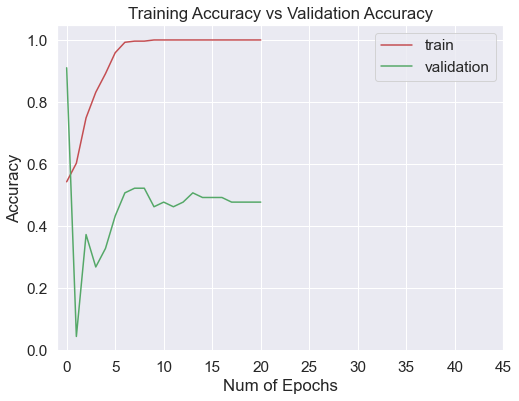

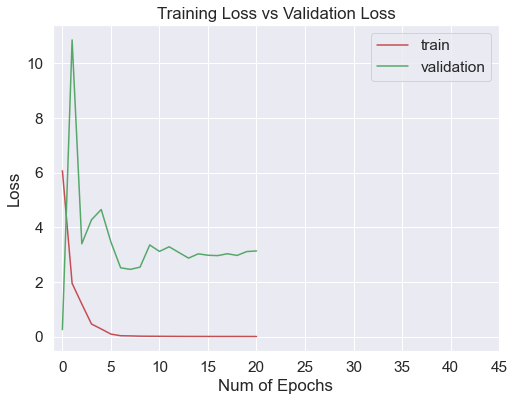

In [43]:
plt.figure(0)  
plt.plot(history.history['accuracy'],'r')  
plt.plot(history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

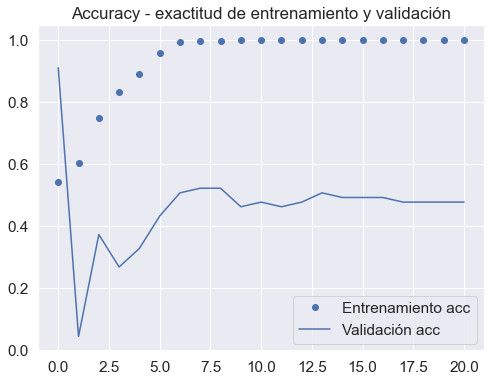

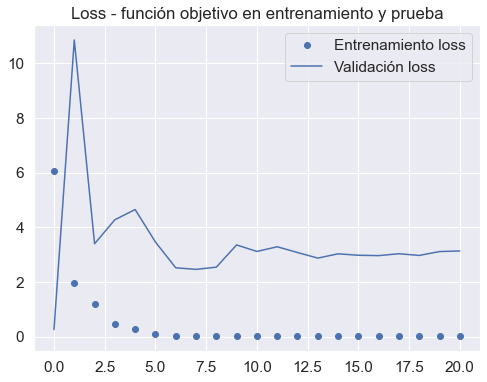

In [44]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

4/4 [==============================] - 4s 979ms/step


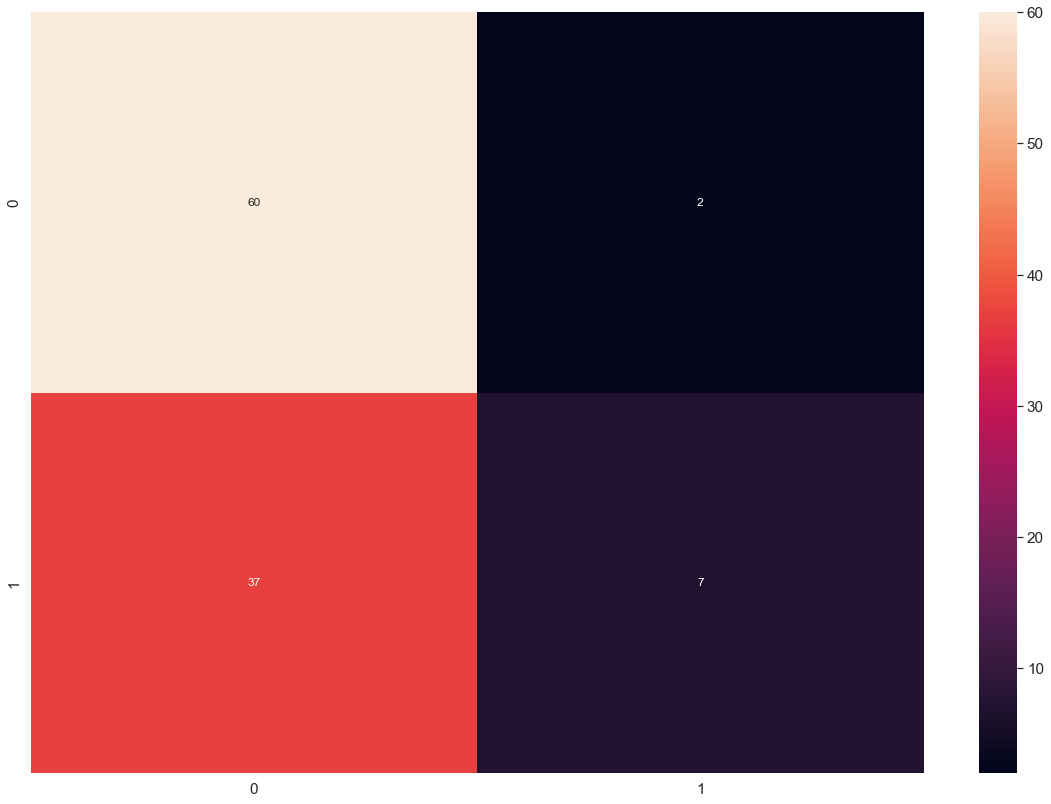

In [45]:
vgg16 = model.predict(test_ds, batch_size=32, verbose=1)  
vgg16_predicted = np.argmax(vgg16, axis=1)

vgg_cm = confusion_matrix(np.argmax(test_labels_categorical, axis=1), vgg16_predicted)

# Visualizing of confusion matrix
vgg_df_cm = pd.DataFrame(vgg_cm, range(2), range(2))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(vgg_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show() 